# SSD Example Using TensorFlow 2 Object Detection API

This example shows how to use the TensorFlow 2 Object Detection API with a pretrained model loaded from the Object Detection zoo, which is available at: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md. In order to run this example, you need TensorFlow2 with the Object Detection API installed. You can use the Conda environment `tensorflow-object-detection` as explained in the top level README.md

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import fiftyone as fo
import fiftyone.zoo as foz

import pathlib
import time
import numpy as np
from PIL import Image
import utils

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

tensorflow version: 2.8.0


In [2]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Use Fiftyone's dataset zoo for downloading images

In [3]:
# Define a dataset and download it
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split=('validation'),
    label_types=["detections"],
    classes=["person", "car", "truck", "traffic light"],
    max_samples=10
)

# View summarty info regarding the dataset
print(dataset)

Ignoring invalid classes ['person', 'car', 'truck', 'traffic light']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v6' split 'validation'
Ignoring invalid classes ['person', 'car', 'truck', 'traffic light']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |███████████████████| 10/10 [24.0ms elapsed, 0s remaining, 416.0 samples/s]     
Dataset 'open-images-v6-validation-10' created
Name:        open-images-v6-validation-10
Media type:  image
Num samples: 10
Persistent:  False
Tags:        ['validation']
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    

## Download the model

Object detection model zoo is available at
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [4]:
# Download a given model from the model zoo
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

# Use Keras' get_file to download the file
path_to_model_dir = tf.keras.utils.get_file(
    fname = 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin = url,
    untar = True)

## Download the labels

https://github.com/tensorflow/models/tree/master/research/object_detection/data

In [5]:
# Download labels
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

path_to_labels = tf.keras.utils.get_file(
    fname = 'mscoco_label_map.pbtxt',
    origin = url,
    untar = False
)

print(f'Path to the labels: {path_to_labels}')
print('Label data: ')
!head {path_to_labels}

Path to the labels: /home/jarno/.keras/datasets/mscoco_label_map.pbtxt
Label data: 
item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


## Load the model

In [6]:
# Load the model
path_to_saved_model = path_to_model_dir + "/saved_model"

print('Loading the model...', end='')
start_time = time.time()

detect_fn = tf.saved_model.load(path_to_saved_model)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'done, time to load the mode: {elapsed_time} seconds')

Loading the model...done, time to load the mode: 21.557510137557983 seconds


## Load the labels

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(
    path_to_labels,
    use_display_name = True)

print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

In [8]:
def detect_objects(image_path):
    print(f'Running inference for {image_path} ... ', end='')
    
    # Load the image
    img = utils.load_image(image_path)
    
    # Convert into a tensor
    input_tensor = tf.convert_to_tensor(img)
    
    # The model expects a batch of images, for individual images we need to add an axis
    # [height, width, 3] -> [1, height, width, 3]
    input_tensor = input_tensor[tf.newaxis, ...]
    
    # Inference
    start_time = time.time()
    detections = detect_fn(input_tensor)
    end_time = time.time()
    
    # Outputs are batches of tensors
    # Convert the tensors into numpy arrays. Since we're feeding single images to the model, we're only
    # interested in the 0:th item.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    img_overlay = img.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        img_overlay,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates = True,
        max_boxes_to_draw = 300,
        min_score_thresh = 0.3,
        agnostic_mode = False)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(img_overlay)
    print(f'done, inference time: {end_time - start_time} seconds')
    plt.show()
    return img_overlay

Running inference for /home/jarno/fiftyone/open-images-v6/validation/data/0001eeaf4aed83f9.jpg ... done, inference time: 5.8318095207214355 seconds


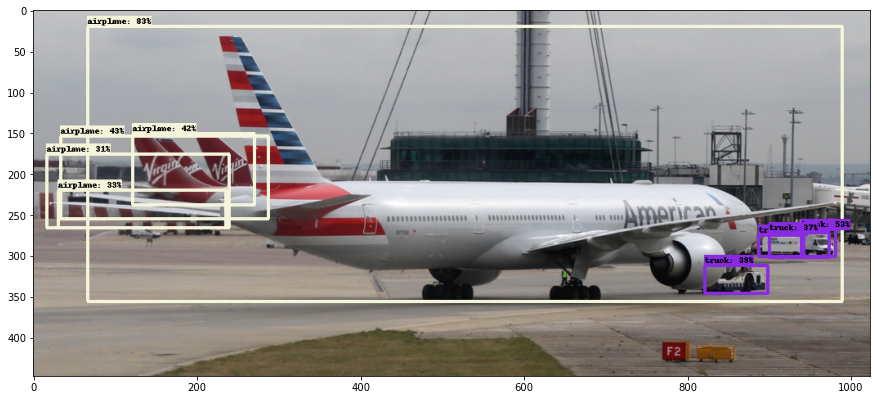

Running inference for /home/jarno/fiftyone/open-images-v6/validation/data/000595fe6fee6369.jpg ... done, inference time: 0.11172890663146973 seconds


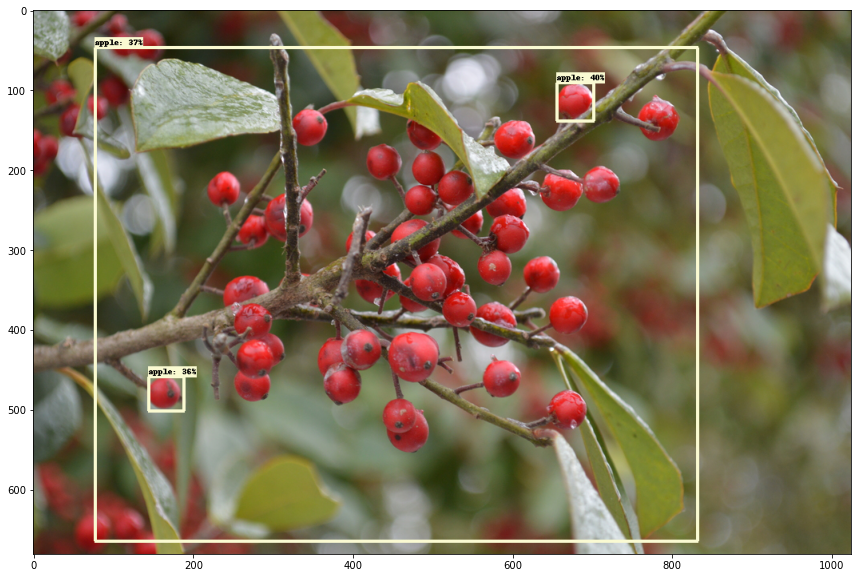

Running inference for /home/jarno/fiftyone/open-images-v6/validation/data/00075905539074f2.jpg ... done, inference time: 0.10914397239685059 seconds


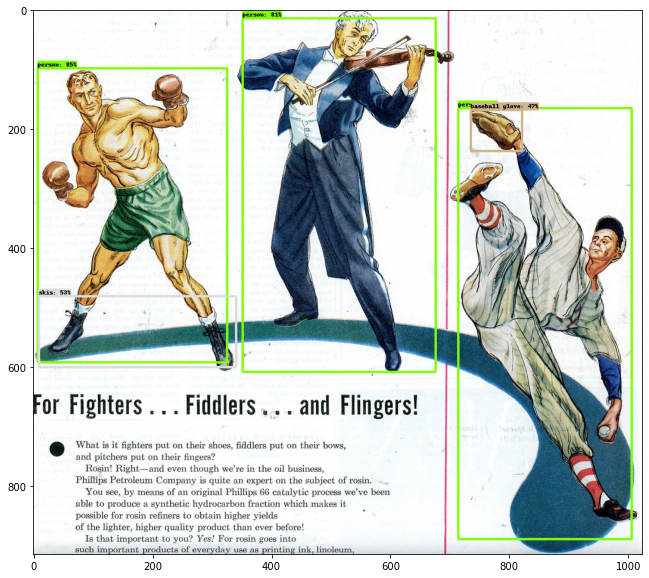

In [9]:
# Get a view to the dataset
view = dataset.match_tags("validation").limit(3)

# Iterate through the view, do inference, and show the results
for image in view:
    img = detect_objects(image.filepath)